<a href="https://colab.research.google.com/github/OindrilaDas27/image-to-text_retrieval/blob/main/image2text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
from transformers import ViTModel, BertModel, BertTokenizer, ViTFeatureExtractor
from torchvision import transforms
from PIL import Image
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!unzip /content/drive/MyDrive/Attention/archive.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/fashionIQ_dataset/images/B00DS3Z5SS.jpg  
  inflating: /content/fashionIQ_dataset/images/B00DS46O5U.jpg  
  inflating: /content/fashionIQ_dataset/images/B00DS4PSSY.jpg  
  inflating: /content/fashionIQ_dataset/images/B00DS4PSUM.jpg  
  inflating: /content/fashionIQ_dataset/images/B00DS4PSV6.jpg  
  inflating: /content/fashionIQ_dataset/images/B00DS4PSXY.jpg  
  inflating: /content/fashionIQ_dataset/images/B00DS5BW6U.jpg  
  inflating: /content/fashionIQ_dataset/images/B00DS5C0KW.jpg  
  inflating: /content/fashionIQ_dataset/images/B00DS5CR6E.jpg  
  inflating: /content/fashionIQ_dataset/images/B00DS5CW3W.jpg  
  inflating: /content/fashionIQ_dataset/images/B00DS5D39E.jpg  
  inflating: /content/fashionIQ_dataset/images/B00DS5HO0S.jpg  
  inflating: /content/fashionIQ_dataset/images/B00DS5NIN0.jpg  
  inflating: /content/fashionIQ_dataset/images/B00DS5NKJW.jpg  
  inflating: /content/fashionIQ_dataset/images/B00DS5

In [ ]:
from transformers import BertTokenizer, BertModel, ViTModel, ViTFeatureExtractor
import torch
import torch.nn as nn
from torch.nn.functional import cosine_similarity

# Load BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Load Vision Transformer (ViT) model and feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224')


In [ ]:
# Custom model for BERT embeddings (Text Embeddings)
class BertForImageRetrieval(nn.Module):
    def __init__(self, bert_model):
        super(BertForImageRetrieval, self).__init__()
        self.bert = bert_model
        self.fc = nn.Linear(768, 512)  # Map to 512-dim embedding

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs[1]  # Pooled [CLS] token output
        return self.fc(pooled_output)

# Custom model for ViT embeddings (Image Embeddings)
class ViTForImageRetrieval(nn.Module):
    def __init__(self, vit_model):
        super(ViTForImageRetrieval, self).__init__()
        self.vit = vit_model
        self.fc = nn.Linear(768, 512)  # Map to 512-dim embedding

    def forward(self, pixel_values):
        outputs = self.vit(pixel_values=pixel_values)
        return self.fc(outputs.pooler_output)


In [ ]:
def contrastive_loss(text_embeddings, image_embeddings, labels):
    similarities = cosine_similarity(text_embeddings, image_embeddings)
    loss = nn.BCELoss()(similarities, labels)
    return loss


In [ ]:
# Training with a loss function where both BERT and ViT models are fine-tuned to produce similar embeddings for related image-text pairs
optimizer = torch.optim.Adam(list(bert_model.parameters()) + list(vit_model.parameters()), lr=1e-5)

epochs = 5
for epoch in range(epochs):
    for batch in dataloader:
        text_embeddings = bert_model(batch['input_ids'], batch['attention_mask'])
        image_embeddings = vit_model(batch['pixel_values'])

        loss = contrastive_loss(text_embeddings, image_embeddings, batch['labels'])
        loss.backward()
        optimizer.step()


In [ ]:
from PIL import Image

# Pre-process the image to match ViT input
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = feature_extractor(images=image, return_tensors="pt")
    return image['pixel_values']

# Extract image embeddings using the fine-tuned ViT model
def get_image_embedding(image_path):
    image = preprocess_image(image_path)
    with torch.no_grad():
        outputs = vit_model(image)
    return outputs.pooler_output.mean(dim=1)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [ ]:
# Extract text embeddings using the fine-tuned BERT model
def get_text_embedding(caption):
    inputs = tokenizer(caption, return_tensors='pt', truncation=True, padding=True)
    with torch.no_grad():
        text_embedding = bert_model(**inputs).pooler_output
    return text_embedding


In [ ]:
import os
import json
import pickle
import math

dataset_image_embs = []
dataset_text_embs = []
dataset_combined_embs = []

caption_dir = '/content/fashionIQ_dataset/captions'

for filename in os.listdir(caption_dir):
    if filename.endswith(".json"):
        caption_file = os.path.join(caption_dir, filename)
        with open(caption_file, 'r') as f:
            captions_data = json.load(f)

        for item in captions_data:
            image_id = item['candidate']
            captions = item['captions']

            image_path = os.path.join('/content/fashionIQ_dataset/images', image_id + ".jpg")
            try:
                image_emb = get_image_embedding(image_path)
                for caption in captions:
                    text_emb = get_text_embedding(caption)
                    combined_emb = (image_id, (image_emb + text_emb) / 2)  # Combine features
                    dataset_combined_embs.append(combined_emb)

            except Exception as e:
                print(f"Error processing image {image_id}: {e}")

# Save the combined embeddings
with open('combined_embeddings.pkl', 'wb') as f:
    pickle.dump(dataset_combined_embs, f)


In [ ]:
import pickle

dest = 'combined_embeddings.pkl'
with open(dest, 'wb') as f:
    pickle.dump(dataset_combined_embs, f)


# Load the embeddings
with open(dest, 'rb') as f:
    dataset_combined_embs = pickle.load(f)

print(f"Number of combined embeddings: {len(dataset_combined_embs)}")
print(dataset_combined_embs[0])

Number of combined embeddings: 60268
('B000FLD4AC', tensor([[-0.0318,  0.0360, -0.1456,  ...,  0.2812, -0.0894,  0.0822]]))


In [ ]:
# Retrieve function to find similar items based on Euclidean distance
def retrieve_similar_items(query_emb, combined_embeds, top_k=5):
    # Convert to numpy arrays for distance calculation
    query_emb = query_emb.cpu().numpy()
    # Convert second element of the tuple to a numpy array for each tuple in combined_embeds
    combined_embeds = [(idx, emb.cpu().numpy()) for idx, emb in combined_embeds]

    distances = {idx: euclidean_distances(query_emb, emb[1]) for idx, emb in enumerate(combined_embeds)}
    similar_items = sorted(distances.items(), key=lambda item: item[1][0], reverse=False)[:top_k]
    # Return the top_k items from combined_embeds based on the sorted distances
    similar_image_ids = [combined_embeds[idx][0] for idx, _ in similar_items]
    return similar_image_ids

Number of combined embeddings: 60268
['B007E66YTO', 'B0054GX8PY', 'B00CWSL250', 'B00CL0URZU', 'B009YMVV6W']


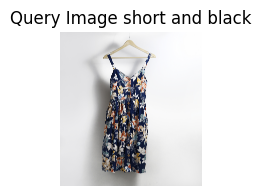

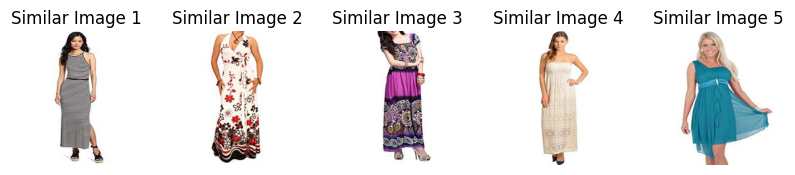

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import os

dest = '/content/drive/MyDrive/Attention/combined_embeddings.pkl'

query_image_path = '/content/example_image.jpg'
query_text = "long dress"

query_image_emb = get_image_embedding(query_image_path)
query_text_emb = get_text_embedding(query_text)

# Combine the embeddings
query_emb = combine_features(query_image_emb, query_text_emb)

# Load the combined embeddings from the file
# make the embeddings a numpy array
with open(dest, 'rb') as f:
    combined_embeds = pickle.load(f)

print(f"Number of combined embeddings: {len(combined_embeds)}")

# Call the retrieve_similar_items function to get the top 5 similar items
similar_images = retrieve_similar_items(query_emb, combined_embeds, top_k=5)
print(similar_images)
# show similar images using pillow along with input image and query text

# Load the query image
query_image = mpimg.imread(query_image_path)
plt.figure(figsize=(2,2))
plt.imshow(query_image)
plt.title(f"Query Image {query_text}")
plt.axis('off')
plt.show()

# Load and display the similar images
plt.figure(figsize=(10, 2))
for i, image_id in enumerate(similar_images):
    image_path = os.path.join('/content/fashionIQ_dataset/images', image_id + ".jpg")
    image = mpimg.imread(image_path)
    plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    plt.title(f"Similar Image {i + 1}")
    plt.axis('off')
plt.show()